# Greenness (gcc) Predictions:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from datetime import date
import datetime
pdf = matplotlib.backends.backend_pdf.PdfPages("GCC_Predictions_Result_Model_3_0325.pdf")

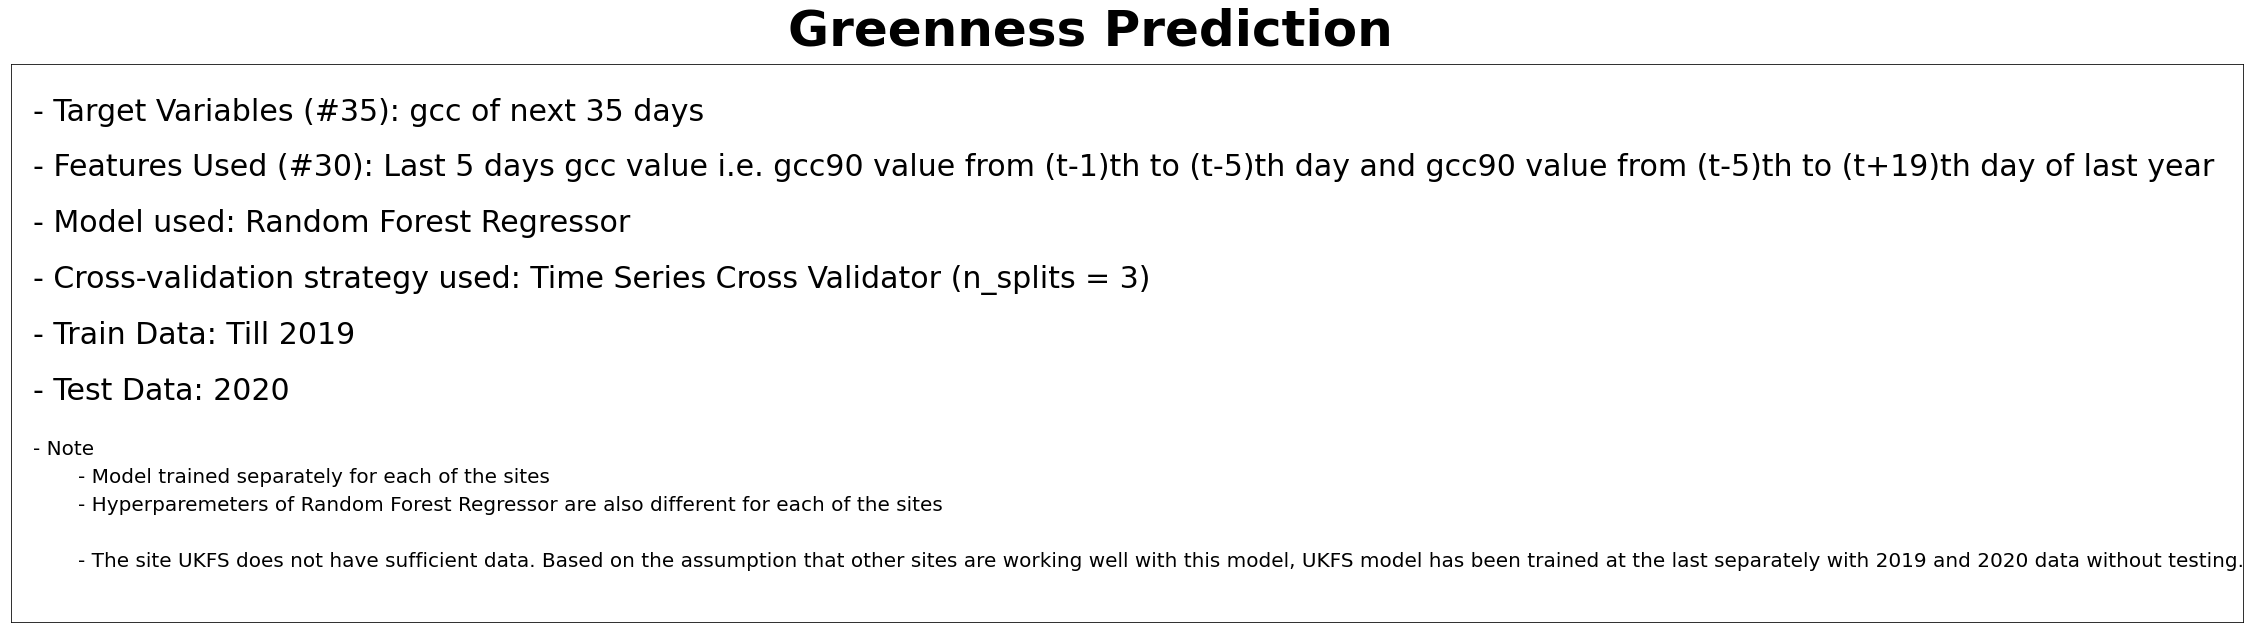

In [2]:
fig = plt.figure(figsize=(40,10))
fig.suptitle('Greenness Prediction', fontsize = 50, fontweight='bold')
#ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(0.01, 0.9, '- Target Variables (#35): gcc of next 35 days', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.8, '- Features Used (#30): Last 5 days gcc value i.e. gcc90 value from (t-1)th to (t-5)th day and gcc90 value from (t-5)th to (t+19)th day of last year', 
         fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.7, '- Model used: Random Forest Regressor', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.6, '- Cross-validation strategy used: Time Series Cross Validator (n_splits = 3)', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.5, '- Train Data: Till 2019', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.4, '- Test Data: 2020', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.3, '- Note', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.25, '- Model trained separately for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.2, '- Hyperparemeters of Random Forest Regressor are also different for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.1, '- The site UKFS does not have sufficient data. Based on the assumption that other sites are working well with this model, UKFS model has been trained at the last separately with 2019 and 2020 data without testing.', fontsize = 20, horizontalalignment = 'left')
pdf.savefig()

In [3]:
# Importing the dataset gcc_weather.csv
url = "https://raw.githubusercontent.com/genophenoenvo/neon-datasets/main/pheno_images/gcc_weather.csv"
dataset = pd.read_csv(url)
print("Shape of imported dataset:" + str(dataset.shape))
print("\nColumns of imported dataset:")
print(dataset.columns)

Shape of imported dataset:(12496, 11)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'gcc_sd', 'daylength', 'precipitation',
       'radiation', 'snow_water_equiv', 'max_temp', 'min_temp',
       'vapor_pressure'],
      dtype='object')


In [4]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
dataset = dataset.set_index("time")

In [5]:
# Selecting the required columns: siteID and gcc90 and date related columns
gcc_data = dataset[["siteID", "gcc_90", "year", "month", "day", "year_month"]]
print("Shape:" + str(gcc_data.shape))
site_list = gcc_data["siteID"].unique()
print("Sites:")
print(site_list)

Shape:(12496, 6)
Sites:
['HARV' 'BART' 'SCBI' 'STEI' 'UKFS' 'GRSM' 'DELA' 'CLBJ']


In [6]:
#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
site_data = []
for i in range(0,8):
    site_data.append(gcc_data_by_site.get_group(site_list[i]))

In [7]:
#Creating features by using shift() function
input_features = []
target_variables = ['gcc_90']
for k in range(0,8):
    for i in range(1,35):    # Creating 35 target variables
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        if(k == 0):
            target_variables.append(col_name_ahead)
        site_data[k].loc[:,col_name_ahead] = site_data[k].loc[:,"gcc_90"].shift(-i)
    for i in range(1,6):     #Creating features columns for last 5 days
        col_name = "gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name)
        site_data[k].loc[:,col_name] = site_data[k].loc[:,"gcc_90"].shift(i)
    for i in range(1,6):     #Creating features columns for last 5 days from last year
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        site_data[k].loc[:,col_name_last_year] = site_data[k].loc[:,"gcc_90"].shift(i+365)
    for i in range(0,20):     #Creating features columns for t to (t+19) days from last year
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        site_data[k].loc[:,col_name_last_year_ahead] = site_data[k].loc[:,"gcc_90"].shift(365-i)

/Users/zeyuchang/miniforge3/envs/spr/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/zeyuchang/miniforge3/envs/spr/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
print("Columns in each of the site's dataframe:")
site_data[0].columns

Columns in each of the site's dataframe:


Index(['siteID', 'gcc_90', 'year', 'month', 'day', 'year_month',
       'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)',
       'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)',
       'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)',
       'gcc_90_(t+13)', 'gcc_90_(t+14)', 'gcc_90_(t+15)', 'gcc_90_(t+16)',
       'gcc_90_(t+17)', 'gcc_90_(t+18)', 'gcc_90_(t+19)', 'gcc_90_(t+20)',
       'gcc_90_(t+21)', 'gcc_90_(t+22)', 'gcc_90_(t+23)', 'gcc_90_(t+24)',
       'gcc_90_(t+25)', 'gcc_90_(t+26)', 'gcc_90_(t+27)', 'gcc_90_(t+28)',
       'gcc_90_(t+29)', 'gcc_90_(t+30)', 'gcc_90_(t+31)', 'gcc_90_(t+32)',
       'gcc_90_(t+33)', 'gcc_90_(t+34)', 'gcc_90_(t-1)', 'gcc_90_(t-2)',
       'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)',
       'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)',
       'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)',
       'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)',
       'last_year_gcc_90_(t+1)', 'last_

In [9]:
print("Input Features:\n" + str(input_features))
print("\nTarget Variables:\n" + str(target_variables))

Input Features:
['gcc_90_(t-1)', 'gcc_90_(t-2)', 'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)', 'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)', 'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)', 'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)', 'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)', 'last_year_gcc_90_(t+8)', 'last_year_gcc_90_(t+9)', 'last_year_gcc_90_(t+10)', 'last_year_gcc_90_(t+11)', 'last_year_gcc_90_(t+12)', 'last_year_gcc_90_(t+13)', 'last_year_gcc_90_(t+14)', 'last_year_gcc_90_(t+15)', 'last_year_gcc_90_(t+16)', 'last_year_gcc_90_(t+17)', 'last_year_gcc_90_(t+18)', 'last_year_gcc_90_(t+19)']

Target Variables:
['gcc_90', 'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)', 'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)', 'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)', 'gcc_90_(t+13)', '

In [10]:
# Calculating baseline gcc_90 for comparison (baseline gcc_90 = average of last 3 years gcc_90 value)
for k in range(0,8):
    df =  site_data[k].copy()
    
    df.drop(pd.Timestamp("2020-02-29"), inplace = True, errors = 'ignore')
    
    baseline_df = df[["siteID"]]
    avg = pd.DataFrame()
    
    avg["ly_1"] = df.loc[:, "gcc_90"].shift(365)
    avg["ly_2"] = df.loc[:, "gcc_90"].shift(365*2)
    avg["ly_3"] = df.loc[:, "gcc_90"].shift(365*3)
    avg["mean"] = avg.mean(axis = 1, skipna = True)
    baseline_df["baseline_gcc_90"] = avg["mean"]
    
    for i in range(1,35):
        baseline_col_name_ahead = "baseline_gcc_90_(t+"+str(i)+")"
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        avg = pd.DataFrame()
        avg["ly_1"] = df.loc[:, col_name_ahead].shift(365)
        avg["ly_2"] = df.loc[:, col_name_ahead].shift(365*2)
        avg["ly_3"] = df.loc[:, col_name_ahead].shift(365*3)
        avg["mean"] = avg.mean(axis = 1, skipna = True)
        baseline_df[baseline_col_name_ahead] = avg["mean"]
    
    baseline_df.drop("siteID", inplace = True, axis =1)
    site_data[k] = site_data[k].join(baseline_df, how ='outer')

<ipython-input-10-1f838476dbc7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["baseline_gcc_90"] = avg["mean"]
<ipython-input-10-1f838476dbc7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df[baseline_col_name_ahead] = avg["mean"]
/Users/zeyuchang/miniforge3/envs/spr/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [11]:
list(site_data[0].columns)

['siteID',
 'gcc_90',
 'year',
 'month',
 'day',
 'year_month',
 'gcc_90_(t+1)',
 'gcc_90_(t+2)',
 'gcc_90_(t+3)',
 'gcc_90_(t+4)',
 'gcc_90_(t+5)',
 'gcc_90_(t+6)',
 'gcc_90_(t+7)',
 'gcc_90_(t+8)',
 'gcc_90_(t+9)',
 'gcc_90_(t+10)',
 'gcc_90_(t+11)',
 'gcc_90_(t+12)',
 'gcc_90_(t+13)',
 'gcc_90_(t+14)',
 'gcc_90_(t+15)',
 'gcc_90_(t+16)',
 'gcc_90_(t+17)',
 'gcc_90_(t+18)',
 'gcc_90_(t+19)',
 'gcc_90_(t+20)',
 'gcc_90_(t+21)',
 'gcc_90_(t+22)',
 'gcc_90_(t+23)',
 'gcc_90_(t+24)',
 'gcc_90_(t+25)',
 'gcc_90_(t+26)',
 'gcc_90_(t+27)',
 'gcc_90_(t+28)',
 'gcc_90_(t+29)',
 'gcc_90_(t+30)',
 'gcc_90_(t+31)',
 'gcc_90_(t+32)',
 'gcc_90_(t+33)',
 'gcc_90_(t+34)',
 'gcc_90_(t-1)',
 'gcc_90_(t-2)',
 'gcc_90_(t-3)',
 'gcc_90_(t-4)',
 'gcc_90_(t-5)',
 'last_year_gcc_90_(t-1)',
 'last_year_gcc_90_(t-2)',
 'last_year_gcc_90_(t-3)',
 'last_year_gcc_90_(t-4)',
 'last_year_gcc_90_(t-5)',
 'last_year_gcc_90_(t+0)',
 'last_year_gcc_90_(t+1)',
 'last_year_gcc_90_(t+2)',
 'last_year_gcc_90_(t+3)',
 'las

In [12]:
# Keeping current year data aside to make predictions later after the model being trained.
current_year_data = []
for k in range(0,8):
    current_year_data.append(site_data[k].loc['2021', :].dropna(subset = input_features))

In [13]:
#drop missing values
for k in range(0,8):
    site_data[k].dropna(subset = input_features + target_variables, inplace = True)

In [14]:
# data count for each year after dropping missing values
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,8):
    data_count[site_list[k]] =  site_data[k].groupby("year").count().iloc[:, 1]
data_count

,HARV,BART,SCBI,STEI,UKFS,GRSM,DELA,CLBJ
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,NaN,8.0,2.0,NaN,NaN,NaN,11.0,NaN
2018,258.0,139.0,113.0,28.0,NaN,216.0,281.0,20.0
2019,231.0,154.0,172.0,285.0,22.0,196.0,322.0,307.0
2020,201.0,189.0,234.0,301.0,189.0,239.0,253.0,276.0
2021,26.0,48.0,48.0,48.0,NaN,47.0,26.0,48.0


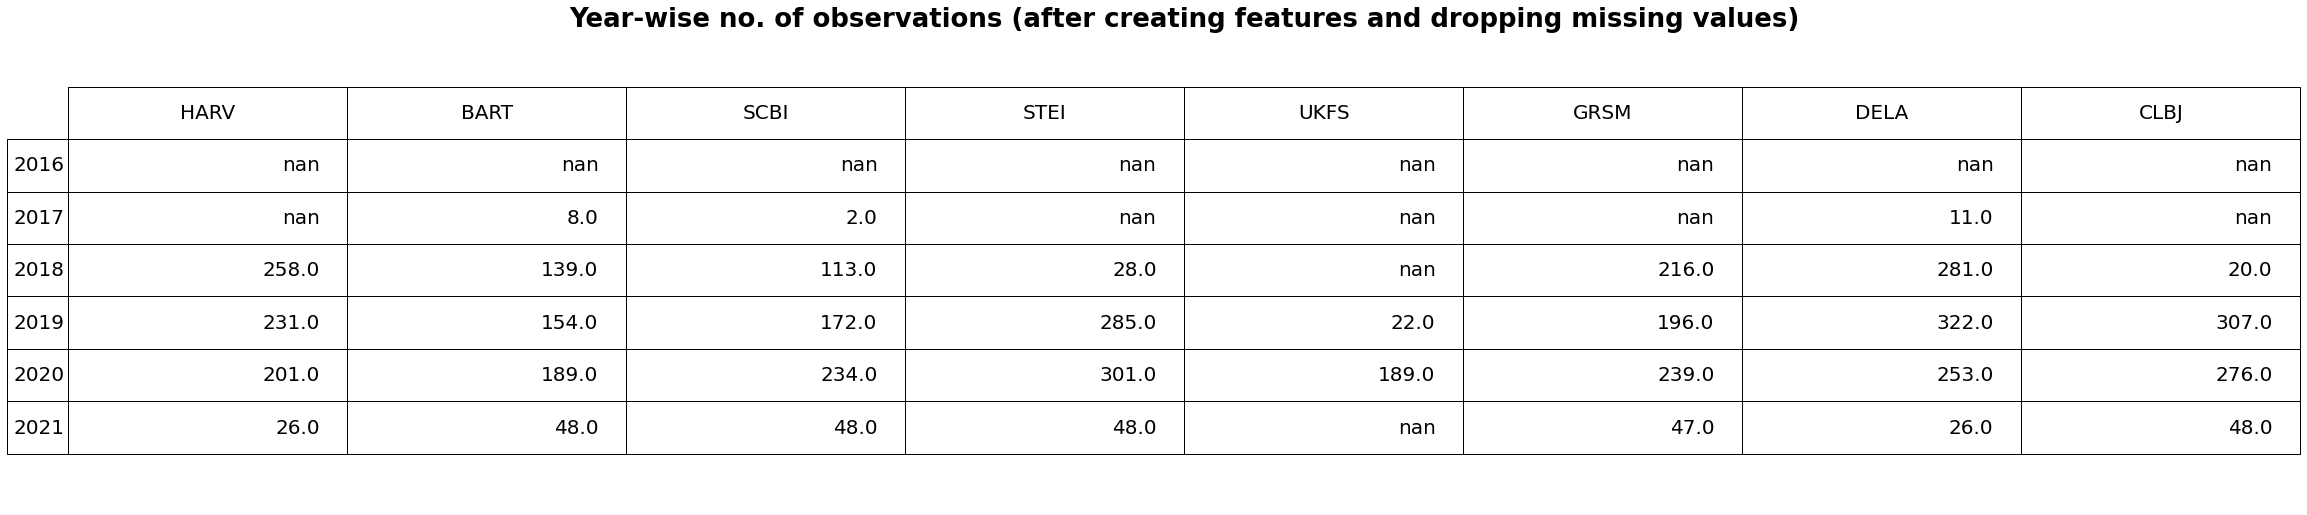

In [15]:
plt.figure(figsize=(40,8))
table = plt.table(np.array(data_count), rowLabels = [2016, 2017, 2018, 2019, 2020, 2021],
                      colLabels = site_list,
                      loc='center')
table.set_fontsize(20)
table.scale(1,4)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title("Year-wise no. of observations (after creating features and dropping missing values)", fontsize = 26, fontweight = 'bold')
plt.subplots_adjust(top=0.950)
#plt.subplots_adjust(bottom=0.10)
fig.tight_layout()
pdf.savefig()

In [16]:
#Train the models
best_models = []
overall_rmse_score = []
overall_r2_score = []
target_variable_wise_score = []
true_results = []
predicted_results = []

for k in range(0,8):
    print("\n" + str(site_list[k]) + ":\n")
    X_train = site_data[k][site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = site_data[k][site_data[k].columns.intersection(target_variables)].loc[:'2019', :]
    X_test = site_data[k][site_data[k].columns.intersection(input_features)].loc['2020', :]
    Y_test = site_data[k][site_data[k].columns.intersection(target_variables)].loc['2020', :]
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of X_train:" + str(Y_train.shape))
    print("Shape of X_train:" + str(X_test.shape))
    print("Shape of X_train:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score.append(rmse)
    overall_r2_score.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


HARV:

Shape of X_train:(489, 30)
Shape of X_train:(489, 35)
Shape of X_train:(201, 30)
Shape of X_train:(201, 35)
RMSE of Training Data: -0.019977555171675813
Model:RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=10,
                      random_state=0)
explained_variance: 0.9608872310035811
RMSE: 0.008596241233919954
R2: 0.9607864502046539
------------------------------------------------------------------------

BART:

Shape of X_train:(301, 30)
Shape of X_train:(301, 35)
Shape of X_train:(189, 30)
Shape of X_train:(189, 35)
RMSE of Training Data: -0.015230971938334345
Model:RandomForestRegressor(max_depth=6, max_features='sqrt', random_state=0)
explained_variance: 0.9665474018650798
RMSE: 0.008175719680440018
R2: 0.9653213733345362
------------------------------------------------------------------------

SCBI:

Shape of X_train:(287, 30)
Shape of X_train:(287, 35)
Shape of X_train:(234, 30)
Shape of X_train:(234, 35)
RMSE of Training Data: -0.01651057815491130

In [17]:
pdf.close()

In [18]:
site_list

array(['HARV', 'BART', 'SCBI', 'STEI', 'UKFS', 'GRSM', 'DELA', 'CLBJ'],
      dtype=object)

In [19]:
best_models

[RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=10,
                       random_state=0),
 RandomForestRegressor(max_depth=6, max_features='sqrt', random_state=0),
 RandomForestRegressor(max_depth=9, max_features='log2', random_state=0),
 RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=20,
                       random_state=0),
 RandomForestRegressor(max_depth=6, random_state=0),
 RandomForestRegressor(max_depth=7, n_estimators=20, random_state=0),
 RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0),
 RandomForestRegressor(max_depth=11, max_features='sqrt', n_estimators=10,
                       random_state=0)]

In [20]:
UKFS_X_train = site_data[4][site_data[4].columns.intersection(input_features)]
UKFS_y_train = site_data[4][site_data[4].columns.intersection(target_variables)]

model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models[4] = best_model
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

RMSE of Training Data: -0.010678881202035783
Model:RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=10,
                      random_state=0)


In [21]:
future_pred_df = []
for i in range(0,8):
    future_pred_df.append(gcc_data_by_site.get_group(site_list[i]))
    future_pred_df[i].reset_index(inplace=True)

In [22]:
for i in range(0,8):
    date_range = pd.date_range(start=future_pred_df[i]["time"].max() + datetime.timedelta(1), 
                               end = date.today() + datetime.timedelta(1) , freq='D')
    future_pred_df[i] = future_pred_df[i].append(pd.DataFrame({'time': date_range, 
                                                               'siteID': site_list[i]}))
    future_pred_df[i].reset_index(inplace = True, drop = True)

In [23]:
for k in range(0,8):
    for i in range(1,6):     #Creating features columns for last 5 days
        col_name = "gcc_90_(t-"+str(i)+")"
        future_pred_df[k].loc[:,col_name] = future_pred_df[k].loc[:,"gcc_90"].shift(i)
        future_pred_df[k].loc[:,col_name] = future_pred_df[k].loc[:,col_name].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(365*i))
        future_pred_df[k].loc[:,col_name] = future_pred_df[k].loc[:,col_name].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(365*2*i))
        future_pred_df[k].loc[:,col_name] = future_pred_df[k].loc[:,col_name].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(365*3*i))
        future_pred_df[k].loc[:,col_name] = future_pred_df[k].loc[:,col_name].ffill(axis = 0)
        
    for i in range(1,6):     #Creating features columns for last 5 days from last year
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        future_pred_df[k].loc[:,col_name_last_year] = future_pred_df[k].loc[:,"gcc_90"].shift(i+365)
        future_pred_df[k].loc[:,col_name_last_year] = future_pred_df[k].loc[:,col_name_last_year].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(i+365*2))
        future_pred_df[k].loc[:,col_name_last_year] = future_pred_df[k].loc[:,col_name_last_year].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(i+365*3))
        future_pred_df[k].loc[:,col_name_last_year] = future_pred_df[k].loc[:,col_name_last_year].ffill(axis=0)
    
    for i in range(0,20):     #Creating features columns for t to (t+19) days from last year
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        future_pred_df[k].loc[:,col_name_last_year_ahead] = future_pred_df[k].loc[:,"gcc_90"].shift(365-i)
        future_pred_df[k].loc[:,col_name_last_year_ahead] = future_pred_df[k].loc[:,col_name_last_year_ahead].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(365*2-i))
        future_pred_df[k].loc[:,col_name_last_year_ahead] = future_pred_df[k].loc[:,col_name_last_year_ahead].fillna(future_pred_df[k].loc[:,"gcc_90"].shift(365*3-i))
        future_pred_df[k].loc[:,col_name_last_year_ahead] = future_pred_df[k].loc[:,col_name_last_year_ahead].ffill(axis=0)

In [24]:
date_index = pd.Timestamp("2021-03-25")
future_pred_date_range = pd.date_range(date_index, periods=35, freq='D')
future_pred_35 = pd.DataFrame(columns = ['time', 'siteID', 'gcc_90'])

for k in range(0,8):
    input_record = future_pred_df[k][future_pred_df[k]["time"] == date_index]
    if(input_record[input_features].isnull().values.any()):
        print("Missing values present in the input features for" + site_list[k])
    future_pred = best_models[k].predict(input_record[input_features])
    
    future_pred_35 = future_pred_35.append(pd.DataFrame({'time': future_pred_date_range, 
                                                  'siteID': site_list[k],
                                                  'gcc_90': pd.Series(future_pred[0])
                                                        }))

last_year_df = dataset[dataset.columns.intersection(['siteID', 'gcc_sd'])].loc['2020',:].reset_index()
last_year_df['time'] = last_year_df['time'].mask(last_year_df['time'].dt.year == 2020, 
                             last_year_df['time'] + pd.offsets.DateOffset(year=2021))
last_year_df = last_year_df.ffill(axis=0)

final_output = pd.merge(left=future_pred_35, right=last_year_df, how='left', left_on=['time','siteID'], right_on=['time','siteID'])
final_output

/Users/zeyuchang/miniforge3/envs/spr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


,time,siteID,gcc_90,gcc_sd
0,2021-03-25,HARV,0.327851,0.000479
1,2021-03-26,HARV,0.328231,0.000479
2,2021-03-27,HARV,0.328544,0.000479
3,2021-03-28,HARV,0.328742,0.000479
4,2021-03-29,HARV,0.329024,0.000479
...,...,...,...,...
275,2021-04-24,CLBJ,0.381833,0.001015
276,2021-04-25,CLBJ,0.380498,0.001066
277,2021-04-26,CLBJ,0.380449,0.000832
278,2021-04-27,CLBJ,0.376953,0.001320


In [25]:
final_output.to_csv('prediction_0325.csv', index=False, header = True)